# Adjoint inverse design of a quantum emitter light extractor

> The cost of running the entire optimization is about 8 FlexCredit (check this)

In this tutorial, we will show how to perform the adjoint-based inverse design of a quantum emitter (QE) light extraction structure. We will use a `PointDipole` to model the QE embedded within an integrated dielectric waveguide. Then, we will build an optimization problem to maximize the extraction efficiency of the dipole radiation into a collection waveguide. In addition, we will show how to use `FieldMonitor` objects in adjoint simulations to calculate the flux radiated from the dipole. You can also find helpful information in this related [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/).

<img src="img/adjoint_12.png" width=400 alt="Schematic of the light extractor">

If you are unfamiliar with inverse design, we recommend the [inverse design lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and this [introductory tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Quickstart/).

Let's start by importing the Python libraries used throughout this notebook.

In [1]:
# Standard python imports.
import pickle
from typing import List

# Import autograd for automatic differentiation.
import autograd as ag
import autograd.numpy as anp
import matplotlib.pylab as plt
import numpy as np
import optax
import scipy as sp

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.autograd import (
    make_erosion_dilation_penalty,
    make_filter_and_project,
    rescale,
    value_and_grad,
)

## Simulation Set Up
The coupling region (design region) extends a single-mode dielectric waveguide placed over a lower refractive index substrate. The QE is modeled as a `PointDipole` oriented in the `y`-direction. The QE is placed within the design region so we surround it with a constant refractive index region to protect it from etching.

In [2]:
# Geometric parameters.
cr_w = 1.0  # Coupling region width (um).
cr_l = 3.0  # Coupling region length (um).
wg_thick = 0.19  # Collection waveguide thickness (um).
wg_width = 0.35  # Collection waveguide width (um).
wg_length = 1.0  # Collection waveguide length (um).

# Material.
n_wg = 3.50  # Structure refractive index.
n_sub = 1.44  # Substrate refractive index.

# Fabrication constraints.
min_feature = 0.06  # Minimum feature size.
non_etch_r = 0.06  # Non-etched circular region radius (um).

# Inverse design set up parameters.
grid_size = 0.015  # Simulation grid size on design region (um).
max_iter = 100  # Maximum number of iterations.
iter_steps = 5  # Beta is increased at each iter_steps.
beta_min = 1.0  # Minimum value for the tanh projection parameter.
learning_rate = 0.02

# Simulation wavelength.
wl = 0.94  # Central simulation wavelength (um).
bw = 0.04  # Simulation bandwidth (um).
n_wl = 41  # Number of wavelength points within the bandwidth.

Let's calculate some variables used throughout the notebook. Here, we will also define the QE position and monitor planes.

In [3]:
# Minimum and maximum values of the permittivity.
eps_max = n_wg**2
eps_min = 1.0

# Material definition.
mat_wg = td.Medium(permittivity=eps_max)
mat_sub = td.Medium(permittivity=n_sub**2)

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 3e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = wg_length + cr_l + pml_spacing
size_y = cr_w + 2 * pml_spacing
size_z = wg_thick + 2 * pml_spacing
eff_inf = 10

# Source position and monitor planes.
cr_center_x = wg_length + cr_l / 2
qe_pos = td.Box(center=(cr_center_x - 0.5, 0, 0), size=(0, 0, 0))
qe_field_plan = td.Box.surfaces(center=(cr_center_x, 0, 0), size=(cr_l, cr_w, 2 * wg_thick))
wg_mode_plan = td.Box(center=(wl / 4, 0, 0), size=(0, 4 * wg_width, 5 * wg_thick))

# Number of points on design grid.
nx_grid = int(cr_l / grid_size)
ny_grid = int(cr_w / grid_size / 2)

# xy coordinates of design grid.
x_grid = np.linspace(cr_center_x - cr_l / 2, cr_center_x + cr_l / 2, nx_grid)
y_grid = np.linspace(0, cr_w / 2, ny_grid)

## Optimization Set Up
We will start defining the density-based optimization functions to transform the design parameters into permittivity values. Here we include the `ConicFilter`, where we impose a minimum feature size fabrication constraint, and the tangent hyperbolic projection function, eliminating intermediary permittivity values as we increase the projection parameter `beta`. You can find more information in the [Inverse design optimization of a compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).

In [4]:
def pre_process(params, beta):
    filter_project = make_filter_and_project(
        radius=min_feature, dl=grid_size, beta=beta, eta=0.5, filter_type="conic"
    )
    params1 = filter_project(params, beta)
    return params1


def get_eps(params, beta: float = 1.00):
    """Returns the permittivities after filter and projection transformations"""
    params1 = pre_process(params, beta=beta)
    eps = eps_min + (eps_max - eps_min) * params1
    eps = anp.maximum(eps, eps_min)
    eps = anp.minimum(eps, eps_max)
    return eps

This function includes a circular region of constant permittivity value surrounding the QE. The objective here is to protect the QE from etching. In applications such as single photon sources, a larger unperturbed region surrounding the QE can be helpful to reduce linewidth broadening, as stated in `J. Liu, K. Konthasinghe, M. Davanco, J. Lawall, V. Anant, V. Verma, R. Mirin, S. Nam, S. Woo, D. Jin, B. Ma, Z. Chen, H. Ni, Z. Niu, K. Srinivasan, "Single Self-Assembled InAs/GaAs Quantum Dots in Photonic Nanostructures: The Role of Nanofabrication," Phys. Rev. Appl. 9(6), 064019 (2018)` [DOI: 10.1103/PhysRevApplied.9.064019](https://link.aps.org/doi/10.1103/PhysRevApplied.9.064019).

In [5]:
def include_constant_regions(eps, circ_center=[0, 0], circ_radius=1.0):
    # Build the geometric mask.
    yv, xv = anp.meshgrid(y_grid, x_grid)

    # Shouldn't this be --> |x-x0|^2 + |y-y0|^2 <= r*2
    geo_mask = (
        anp.where(
            anp.abs((xv - circ_center[0]) ** 2 + (yv - circ_center[1]) ** 2) <= (circ_radius**2),
            1,
            0,
        )
        * eps_max
    )
    eps = anp.maximum(geo_mask, eps)
    return eps

Now, we define a function to update the `td.CustomMedium` using the permittivity distribution. The simulation will include mirror symmetry concerning the `y`-direction, so only the upper half of the design region is returned by this function during the optimization process. To get the whole structure, you need to set `unfold=True`.

In [6]:
def update_design(eps, unfold=False) -> List[td.Structure]:
    # Definition of the coordinates x,y along the design region.
    coords_x = [(cr_center_x - cr_l / 2) + ix * grid_size for ix in range(nx_grid)]
    eps_val = anp.array(eps).reshape((nx_grid, ny_grid, 1))

    if not unfold:
        coords_yp = [0 + iy * grid_size for iy in range(ny_grid)]
        coords = dict(x=coords_x, y=coords_yp, z=[0])
        eps1 = td.SpatialDataArray(eps_val, coords)
        eps_medium = td.CustomMedium(permittivity=eps1)
        box = td.Box(center=(cr_center_x, cr_w / 4, 0), size=(cr_l, cr_w / 2, wg_thick))
        structure = [td.Structure(geometry=box, medium=eps_medium)]

    # VJP for one of anp.copy(), anp.concatenate(), or anp.fliplr() not defined,
    # so the optimization should only be run with `unfold=False` for now
    else:
        coords_y = [-cr_w / 2 + iy * grid_size for iy in range(2 * ny_grid)]
        coords = dict(x=coords_x, y=coords_y, z=[0])
        eps1 = td.SpatialDataArray(
            anp.concatenate((anp.fliplr(anp.copy(eps_val)), eps_val), axis=1), coords
        )
        eps_medium = td.CustomMedium(permittivity=eps1)
        box = td.Box(center=(cr_center_x, 0, 0), size=(cr_l, cr_w, wg_thick))
        structure = [td.Structure(geometry=box, medium=eps_medium)]
    return structure

In the next cell, we define the output waveguide and the substrate, as well as the simulation monitors. It is worth mentioning the inclusion of a `ModeMonitor` in the output waveguide and a `FieldMonitor` box surrounding the dipole source to calculate the total radiated power.

In [7]:
# Input/output waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -wg_width / 2, -wg_thick / 2),
        rmax=(wg_length, wg_width / 2, wg_thick / 2),
    ),
    medium=mat_wg,
)

# Substrate layer.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -wg_thick / 2)
    ),
    medium=mat_sub,
)

# Point dipole source located at the center of TiO2 thin film.
dp_source = td.PointDipole(
    center=qe_pos.center,
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    polarization="Ey",
)

# Mode monitor to compute the FOM.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor_fom = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=[freq],
    mode_spec=mode_spec,
    name="mode_monitor_fom",
)

# Field monitor to compute the FOM.
field_monitor_fom = []
for i, plane in enumerate(qe_field_plan):
    field_monitor_fom.append(
        td.FieldMonitor(
            center=plane.center,
            size=plane.size,
            freqs=[freq],
            name=f"field_monitor_fom_{i}",
        )
    )

# Mode monitor to compute spectral response.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_monitor",
)

# Field monitor to compute spectral response.
field_monitor = []
for i, plane in enumerate(qe_field_plan):
    field_monitor.append(
        td.FieldMonitor(
            center=plane.center, size=plane.size, freqs=freqs, name=f"field_monitor_{i}"
        )
    )

# Field monitor to visualize the fields.
field_monitor_xy = td.FieldMonitor(
    center=(size_x / 2, 0, 0),
    size=(size_x, size_y, 0),
    freqs=freqs,
    name="field_xy",
)

Lastly, we have a function that receives the design parameters from the optimization algorithm and then gathers the simulation objects altogether to create a `td.Simulation`.

In [8]:
def make_adjoint_sim(param, beta: float = 1.00, unfold=False):
    eps = get_eps(param, beta)
    eps = include_constant_regions(
        eps, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r
    )
    structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(center=(cr_center_x, 0, 0), size=(cr_w, cr_l, wg_thick)),
        dl=[grid_size, grid_size, grid_size],
        enforce=True,
    )

    grid_spec = td.GridSpec.auto(
        wavelength=wl_max,
        min_steps_per_wvl=15,
        override_structures=[adjoint_dr_mesh],
    )

    return td.Simulation(
        size=[size_x, size_y, size_z],
        center=[size_x / 2, 0, 0],
        grid_spec=grid_spec,
        symmetry=(0, -1, 0),
        structures=[substrate, waveguide] + structure,
        sources=[dp_source],
        monitors=[field_monitor_xy, mode_monitor_fom] + field_monitor_fom,
        run_time=run_time,
        subpixel=True,
    )

## Initial Light Extractor Structure
Let's create a uniform initial permittivity distribution and verify if all the simulation objects are in the correct places.

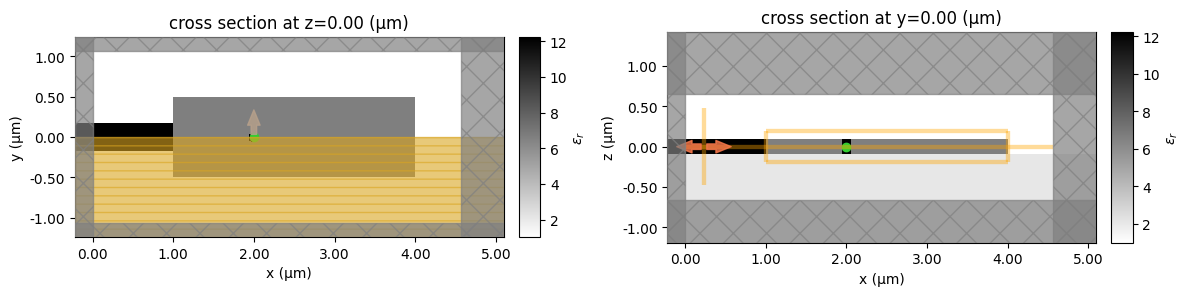

In [9]:
init_par = np.ones((nx_grid, ny_grid)) * 0.5
init_design = make_adjoint_sim(init_par, beta=beta_min, unfold=True)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
init_design.plot_eps(z=0, ax=ax1, monitor_alpha=0.0)
init_design.plot_eps(y=0, ax=ax2)
plt.show()

We will also look at the collection waveguide mode to ensure we have considered the correct one in the `ModeMonitor` setup. We use the `ModeSolver` plugin to calculate the first two waveguide modes, as below.

In [10]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

sim_init = init_design.updated_copy(monitors=[field_monitor_xy, mode_monitor] + field_monitor)

mode_solver = ModeSolver(
    simulation=sim_init,
    plane=wg_mode_plan,
    mode_spec=td.ModeSpec(num_modes=2),
    freqs=[freq],
)
modes = run_mode_solver(mode_solver, reduce_simulation=True)

16:10:23 CEST Mode solver created with                                          
              task_id='fdve-65e65354-aedf-458c-a514-a7eccc5e4b24',              
              solver_id='mo-581ee868-4940-489c-bab0-2c43f11c8df2'.

Output()

Output()

16:10:26 CEST Mode solver status: queued

16:10:28 CEST Mode solver status: running

16:10:32 CEST Mode solver status: success

Output()

After inspecting the mode field distribution, we can confirm that the fundamental waveguide mode is mainly oriented in the `y`-direction, thus matching the dipole orientation.

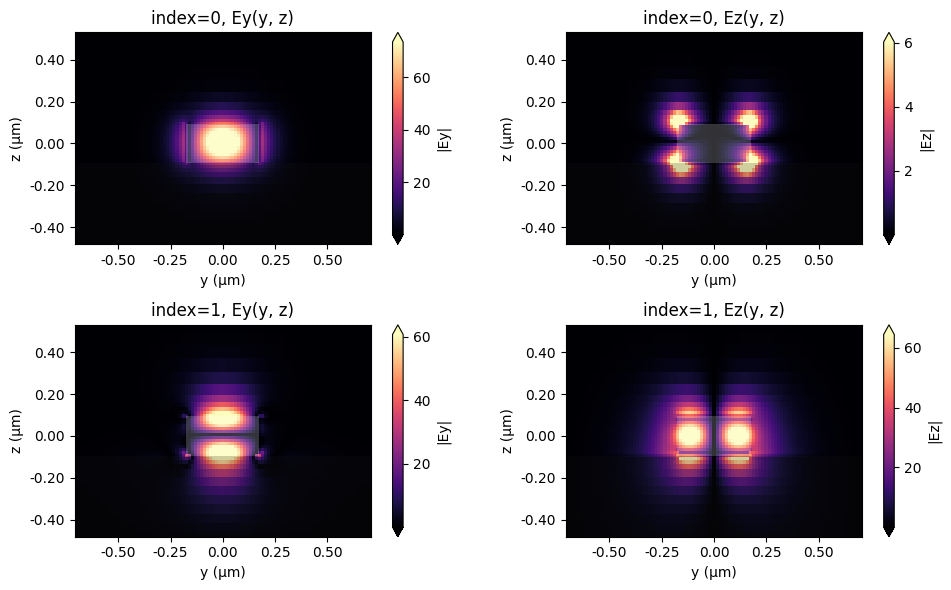

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
for mode_ind in range(2):
    for field_ind, field_name in enumerate(("Ey", "Ez")):
        ax = axs[mode_ind, field_ind]
        mode_solver.plot_field(field_name, "abs", mode_index=mode_ind, f=freq, ax=ax)
        ax.set_title(f"index={mode_ind}, {field_name}(y, z)")

Then, we will calculate the initial coupling efficiency to see how this random structure performs.

In [12]:
sim_data = web.run(sim_init, task_name="initial QE light extractor (Autograd)")

16:10:35 CEST Created task 'initial QE light extractor (Autograd)' with task_id 
              'fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=764587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=560610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\taskId]8;;\]8;id=764587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\=]8;;\]8;id=13753;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\fdve]8;;\]8;id=764587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\-4ca772ae-ba]8;;\
              ]8;id=764587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ca772ae-badc-4827-8da8-4b32cf325ab4\dc-4827-8da8-4b32cf325ab4']8;;\.

              Task folder: ]8;id=708177;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

16:10:37 CEST Maximum FlexCredit cost: 0.060. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

16:10:38 CEST status = success

Output()

16:10:43 CEST loading simulation from simulation_data.hdf5

The modal coupling efficiency is normalized by the dipole power. That is necessary because the dipole power will likely change significantly when the optimization algorithm modifies the design region.

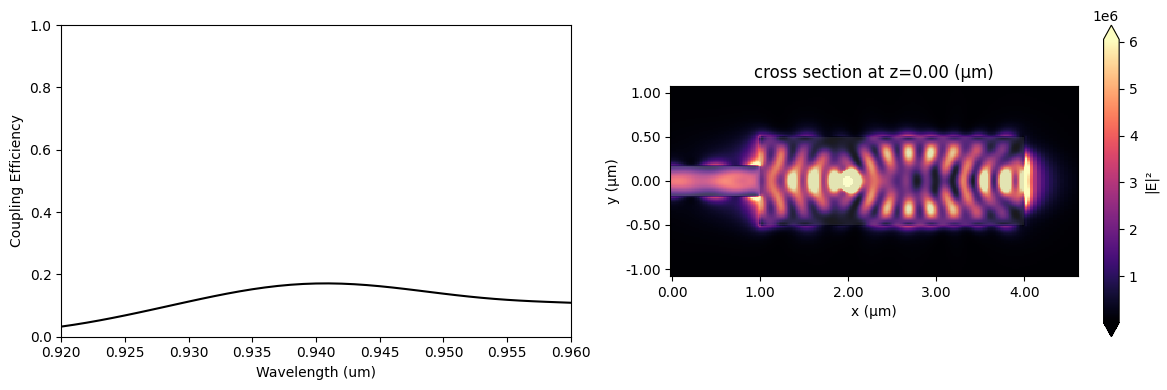

In [13]:
mode_amps = sim_data["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)

coup_eff = mode_power / dip_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
sim_data.plot_field("field_xy", "E", "abs^2", z=0, ax=ax2, f=freq)
plt.show()

## Optimization
The objective function defined next is the device figure-of-merit (FOM) minus a fabrication penalty.

In [14]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: td.SimulationData) -> float:
    """Return the coupling efficiency."""
    # best to use autograd-wrapped numpy functions for differentiation
    mode_amps = sim_data["mode_monitor_fom"].amps.sel(direction="-", f=freq, mode_index=0).data
    mode_power = anp.sum(anp.abs(mode_amps) ** 2)

    # unlike Jax version, should avoid in-place operators (e.g, `+=`), use numpy when possible
    field_mon_list = [sim_data[f"field_monitor_fom_{i}"] for i in range(0, 6)]
    dip_power = anp.sum([anp.abs(mon.flux.data) for mon in field_mon_list])

    return mode_power, dip_power


def penalty(params, beta) -> float:
    """Penalize changes in structure after erosion and dilation to enforce larger feature sizes."""
    params_processed = pre_process(params, beta=beta)
    erode_dilate_penalty = make_erosion_dilation_penalty(radius=min_feature, dl=grid_size)
    ed_penalty = erode_dilate_penalty(params_processed)
    return ed_penalty


# Objective function to be passed to the optimization algorithm.
def obj(param, beta: float = 1.0, step_num: int = None, verbose: bool = False) -> float:
    sim = make_adjoint_sim(param, beta, unfold=False)  # non-differentiable if `unfold=True`
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = web.run(sim, task_name=task_name, verbose=verbose)
    mode_power, dip_power = fom(sim_data)
    fom_val = mode_power / dip_power
    penalty_weight = 0.1
    penalty_val = penalty(param, beta)
    J = fom_val - penalty_weight * penalty_val
    return J, [sim_data, mode_power, dip_power, penalty_val]


# Function to calculate the objective function value and its gradient with respect to the design parameters.
# Use tidy3d's wrapped ag.value_and_grad() for it's auxiliary data functionality
obj_grad = value_and_grad(obj, has_aux=True)

In the following cell, we define some functions to save the optimization progress and load a previous optimization from the file.

In [15]:
# where to store history
history_fname = "misc/qe_light_coupler_autograd.pkl"


def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history_dict, file)


def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history_dict = pickle.load(file)
    return history_dict

Then, we will start a new optimization or load the parameters of a previous one.

In [16]:
# initialize adam optimizer with starting parameters
optimizer = optax.adam(learning_rate=learning_rate)

try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    opt_state = optimizer.init(params)
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(f"Found {num_iters_completed} iterations previously completed out of {max_iter} total.")
    if num_iters_completed < max_iter:
        print("Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    params = anp.array(init_par)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        coupl_eff=[],
        penalty=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
        data=[],
        beta=[],
    )

In the optimization loop, we will gradually increase the projection parameter `beta` to eliminate intermediary permittivity values. At each iteration, we record the design parameters and the optimization history to restore them as needed.

Iteration = (1 / 100)


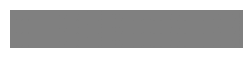

	beta = 1.0
	J = 7.1432e-02
	grad_norm = 6.8739e-02
	penalty = 1.000
	mode power = 473.968
	dip power = 2764.752
	coupling efficiency = 0.171
Iteration = (2 / 100)


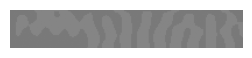

	beta = 1.0
	J = 2.2832e-01
	grad_norm = 7.1512e-02
	penalty = 1.000
	mode power = 1002.394
	dip power = 3053.089
	coupling efficiency = 0.328
Iteration = (3 / 100)


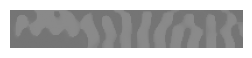

	beta = 1.0
	J = 3.7482e-01
	grad_norm = 6.4898e-02
	penalty = 1.000
	mode power = 1478.833
	dip power = 3114.501
	coupling efficiency = 0.475
Iteration = (4 / 100)


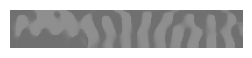

	beta = 1.0
	J = 4.9571e-01
	grad_norm = 5.6425e-02
	penalty = 1.000
	mode power = 1935.575
	dip power = 3249.175
	coupling efficiency = 0.596
Iteration = (5 / 100)


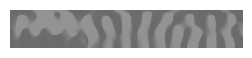

	beta = 1.0
	J = 5.8980e-01
	grad_norm = 4.6824e-02
	penalty = 1.000
	mode power = 2418.556
	dip power = 3506.185
	coupling efficiency = 0.690
Iteration = (6 / 100)


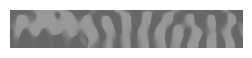

	beta = 2.0
	J = 6.9596e-01
	grad_norm = 5.4160e-02
	penalty = 1.000
	mode power = 3059.636
	dip power = 3843.981
	coupling efficiency = 0.796
Iteration = (7 / 100)


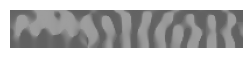

	beta = 2.0
	J = 7.4070e-01
	grad_norm = 3.8978e-02
	penalty = 1.000
	mode power = 3716.945
	dip power = 4421.261
	coupling efficiency = 0.841
Iteration = (8 / 100)


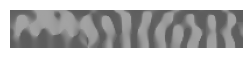

	beta = 2.0
	J = 7.7138e-01
	grad_norm = 3.0304e-02
	penalty = 1.000
	mode power = 4429.873
	dip power = 5083.755
	coupling efficiency = 0.871
Iteration = (9 / 100)


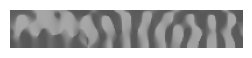

	beta = 2.0
	J = 7.9249e-01
	grad_norm = 2.9056e-02
	penalty = 1.000
	mode power = 5169.262
	dip power = 5791.995
	coupling efficiency = 0.892
Iteration = (10 / 100)


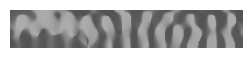

	beta = 2.0
	J = 8.0856e-01
	grad_norm = 2.8136e-02
	penalty = 1.000
	mode power = 6042.956
	dip power = 6651.128
	coupling efficiency = 0.909
Iteration = (11 / 100)


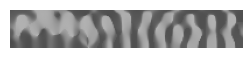

	beta = 3.0
	J = 7.9742e-01
	grad_norm = 9.7527e-02
	penalty = 1.000
	mode power = 7003.191
	dip power = 7803.999
	coupling efficiency = 0.897
Iteration = (12 / 100)


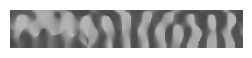

	beta = 3.0
	J = 8.3259e-01
	grad_norm = 3.7221e-02
	penalty = 0.999
	mode power = 8407.922
	dip power = 9016.226
	coupling efficiency = 0.933
Iteration = (13 / 100)


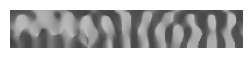

	beta = 3.0
	J = 8.2696e-01
	grad_norm = 6.7464e-02
	penalty = 0.999
	mode power = 8736.356
	dip power = 9425.743
	coupling efficiency = 0.927
Iteration = (14 / 100)


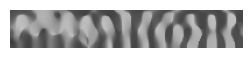

	beta = 3.0
	J = 8.1778e-01
	grad_norm = 1.0335e-01
	penalty = 0.999
	mode power = 8016.955
	dip power = 8736.591
	coupling efficiency = 0.918
Iteration = (15 / 100)


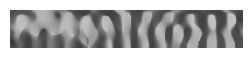

	beta = 3.0
	J = 8.3701e-01
	grad_norm = 7.7907e-02
	penalty = 0.998
	mode power = 7685.024
	dip power = 8203.539
	coupling efficiency = 0.937
Iteration = (16 / 100)


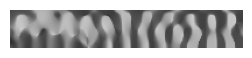

	beta = 4.0
	J = 8.1204e-01
	grad_norm = 1.5668e-01
	penalty = 0.983
	mode power = 5820.384
	dip power = 6393.784
	coupling efficiency = 0.910
Iteration = (17 / 100)


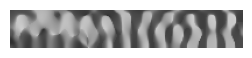

	beta = 4.0
	J = 8.4011e-01
	grad_norm = 1.0337e-01
	penalty = 0.977
	mode power = 7501.458
	dip power = 7998.690
	coupling efficiency = 0.938
Iteration = (18 / 100)


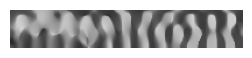

	beta = 4.0
	J = 8.6124e-01
	grad_norm = 2.8364e-02
	penalty = 0.971
	mode power = 10468.018
	dip power = 10923.463
	coupling efficiency = 0.958
Iteration = (19 / 100)


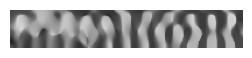

	beta = 4.0
	J = 8.5361e-01
	grad_norm = 7.5763e-02
	penalty = 0.963
	mode power = 13775.781
	dip power = 14501.615
	coupling efficiency = 0.950
Iteration = (20 / 100)


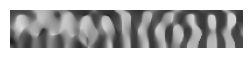

	beta = 4.0
	J = 8.5295e-01
	grad_norm = 8.1482e-02
	penalty = 0.956
	mode power = 16346.014
	dip power = 17233.051
	coupling efficiency = 0.949
Iteration = (21 / 100)


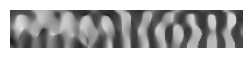

	beta = 5.0
	J = 8.7218e-01
	grad_norm = 5.7052e-02
	penalty = 0.875
	mode power = 17111.887
	dip power = 17829.989
	coupling efficiency = 0.960
Iteration = (22 / 100)


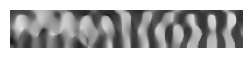

	beta = 5.0
	J = 8.8005e-01
	grad_norm = 5.3833e-02
	penalty = 0.865
	mode power = 17308.501
	dip power = 17908.051
	coupling efficiency = 0.967
Iteration = (23 / 100)


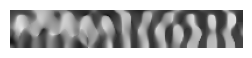

	beta = 5.0
	J = 8.8289e-01
	grad_norm = 3.2505e-02
	penalty = 0.854
	mode power = 15082.259
	dip power = 15576.252
	coupling efficiency = 0.968
Iteration = (24 / 100)


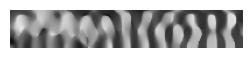

	beta = 5.0
	J = 8.8113e-01
	grad_norm = 4.4331e-02
	penalty = 0.843
	mode power = 12419.322
	dip power = 12863.968
	coupling efficiency = 0.965
Iteration = (25 / 100)


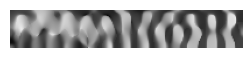

	beta = 5.0
	J = 8.7947e-01
	grad_norm = 6.3651e-02
	penalty = 0.832
	mode power = 12087.040
	dip power = 12555.809
	coupling efficiency = 0.963
Iteration = (26 / 100)


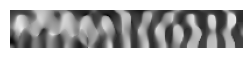

	beta = 6.0
	J = 8.8584e-01
	grad_norm = 7.8859e-02
	penalty = 0.732
	mode power = 10924.212
	dip power = 11390.265
	coupling efficiency = 0.959
Iteration = (27 / 100)


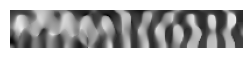

	beta = 6.0
	J = 8.9808e-01
	grad_norm = 3.3468e-02
	penalty = 0.722
	mode power = 17336.079
	dip power = 17867.154
	coupling efficiency = 0.970
Iteration = (28 / 100)


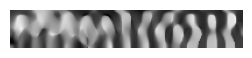

	beta = 6.0
	J = 9.0230e-01
	grad_norm = 7.8044e-02
	penalty = 0.712
	mode power = 25590.844
	dip power = 26288.327
	coupling efficiency = 0.973
Iteration = (29 / 100)


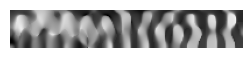

	beta = 6.0
	J = 8.9802e-01
	grad_norm = 9.3922e-02
	penalty = 0.702
	mode power = 26559.148
	dip power = 27429.898
	coupling efficiency = 0.968
Iteration = (30 / 100)


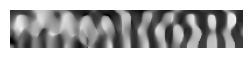

	beta = 6.0
	J = 8.9534e-01
	grad_norm = 7.9459e-02
	penalty = 0.694
	mode power = 21200.802
	dip power = 21975.043
	coupling efficiency = 0.965
Iteration = (31 / 100)


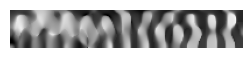

	beta = 7.0
	J = 8.9894e-01
	grad_norm = 1.4495e-01
	penalty = 0.610
	mode power = 11024.127
	dip power = 11483.994
	coupling efficiency = 0.960
Iteration = (32 / 100)


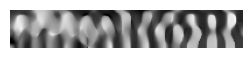

	beta = 7.0
	J = 9.0821e-01
	grad_norm = 7.0287e-02
	penalty = 0.604
	mode power = 15566.298
	dip power = 16071.417
	coupling efficiency = 0.969
Iteration = (33 / 100)


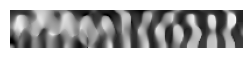

	beta = 7.0
	J = 9.0284e-01
	grad_norm = 1.1942e-01
	penalty = 0.597
	mode power = 24449.286
	dip power = 25399.992
	coupling efficiency = 0.963
Iteration = (34 / 100)


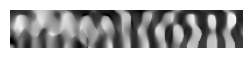

	beta = 7.0
	J = 9.0576e-01
	grad_norm = 1.2081e-01
	penalty = 0.591
	mode power = 25232.320
	dip power = 26150.739
	coupling efficiency = 0.965
Iteration = (35 / 100)


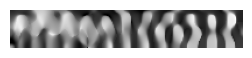

	beta = 7.0
	J = 9.1589e-01
	grad_norm = 4.2125e-02
	penalty = 0.585
	mode power = 18147.493
	dip power = 18623.626
	coupling efficiency = 0.974
Iteration = (36 / 100)


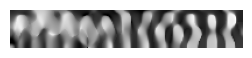

	beta = 8.0
	J = 9.1102e-01
	grad_norm = 1.3288e-01
	penalty = 0.522
	mode power = 8422.290
	dip power = 8743.769
	coupling efficiency = 0.963
Iteration = (37 / 100)


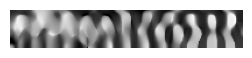

	beta = 8.0
	J = 9.1466e-01
	grad_norm = 1.2887e-01
	penalty = 0.518
	mode power = 11193.142
	dip power = 11582.000
	coupling efficiency = 0.966
Iteration = (38 / 100)


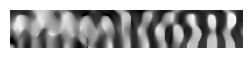

	beta = 8.0
	J = 9.2233e-01
	grad_norm = 4.5024e-02
	penalty = 0.514
	mode power = 22909.328
	dip power = 23528.628
	coupling efficiency = 0.974
Iteration = (39 / 100)


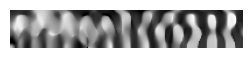

	beta = 8.0
	J = 9.1957e-01
	grad_norm = 1.8263e-01
	penalty = 0.510
	mode power = 33641.288
	dip power = 34663.037
	coupling efficiency = 0.971
Iteration = (40 / 100)


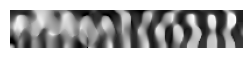

	beta = 8.0
	J = 9.2188e-01
	grad_norm = 9.1393e-02
	penalty = 0.505
	mode power = 29094.673
	dip power = 29920.135
	coupling efficiency = 0.972
Iteration = (41 / 100)


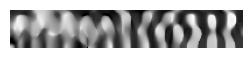

	beta = 9.0
	J = 9.1973e-01
	grad_norm = 1.7000e-01
	penalty = 0.458
	mode power = 10998.133
	dip power = 11390.796
	coupling efficiency = 0.966
Iteration = (42 / 100)


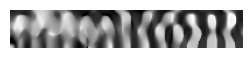

	beta = 9.0
	J = 9.2859e-01
	grad_norm = 9.8428e-02
	penalty = 0.454
	mode power = 11288.366
	dip power = 11589.890
	coupling efficiency = 0.974
Iteration = (43 / 100)


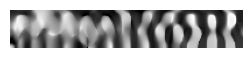

	beta = 9.0
	J = 9.2298e-01
	grad_norm = 1.3906e-01
	penalty = 0.450
	mode power = 16924.833
	dip power = 17484.737
	coupling efficiency = 0.968
Iteration = (44 / 100)


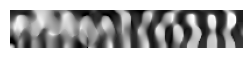

	beta = 9.0
	J = 9.2668e-01
	grad_norm = 1.0958e-01
	penalty = 0.446
	mode power = 28103.075
	dip power = 28934.711
	coupling efficiency = 0.971
Iteration = (45 / 100)


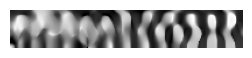

	beta = 9.0
	J = 9.2947e-01
	grad_norm = 1.2422e-01
	penalty = 0.441
	mode power = 35342.692
	dip power = 36301.386
	coupling efficiency = 0.974
Iteration = (46 / 100)


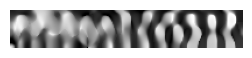

	beta = 10.0
	J = 9.1725e-01
	grad_norm = 2.0425e-01
	penalty = 0.402
	mode power = 22519.909
	dip power = 23521.792
	coupling efficiency = 0.957
Iteration = (47 / 100)


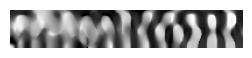

	beta = 10.0
	J = 9.3295e-01
	grad_norm = 8.7255e-02
	penalty = 0.397
	mode power = 27879.178
	dip power = 28662.293
	coupling efficiency = 0.973
Iteration = (48 / 100)


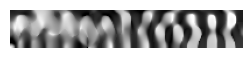

	beta = 10.0
	J = 9.2987e-01
	grad_norm = 1.6063e-01
	penalty = 0.393
	mode power = 36241.082
	dip power = 37392.982
	coupling efficiency = 0.969
Iteration = (49 / 100)


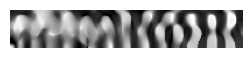

	beta = 10.0
	J = 9.3010e-01
	grad_norm = 1.5227e-01
	penalty = 0.388
	mode power = 34755.844
	dip power = 35869.977
	coupling efficiency = 0.969
Iteration = (50 / 100)


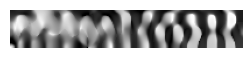

	beta = 10.0
	J = 9.3480e-01
	grad_norm = 8.6082e-02
	penalty = 0.383
	mode power = 24952.972
	dip power = 25642.153
	coupling efficiency = 0.973
Iteration = (51 / 100)


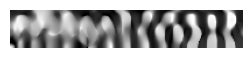

	beta = 11.0
	J = 9.2062e-01
	grad_norm = 2.6132e-01
	penalty = 0.353
	mode power = 14742.606
	dip power = 15421.940
	coupling efficiency = 0.956
Iteration = (52 / 100)


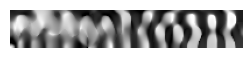

	beta = 11.0
	J = 9.3850e-01
	grad_norm = 6.0557e-02
	penalty = 0.351
	mode power = 30944.033
	dip power = 31783.785
	coupling efficiency = 0.974
Iteration = (53 / 100)


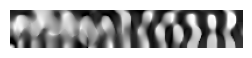

	beta = 11.0
	J = 9.2657e-01
	grad_norm = 4.5544e-01
	penalty = 0.349
	mode power = 62661.433
	dip power = 65175.091
	coupling efficiency = 0.961
Iteration = (54 / 100)


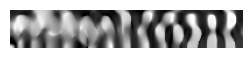

	beta = 11.0
	J = 9.3726e-01
	grad_norm = 1.3739e-01
	penalty = 0.344
	mode power = 26083.433
	dip power = 26843.055
	coupling efficiency = 0.972
Iteration = (55 / 100)


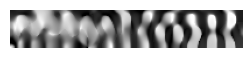

	beta = 11.0
	J = 9.3110e-01
	grad_norm = 2.7552e-01
	penalty = 0.340
	mode power = 14073.962
	dip power = 14582.365
	coupling efficiency = 0.965
Iteration = (56 / 100)


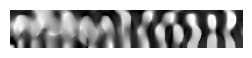

	beta = 12.0
	J = 9.3442e-01
	grad_norm = 2.0789e-01
	penalty = 0.318
	mode power = 10793.581
	dip power = 11171.070
	coupling efficiency = 0.966
Iteration = (57 / 100)


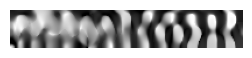

	beta = 12.0
	J = 9.3674e-01
	grad_norm = 2.0010e-01
	penalty = 0.316
	mode power = 24160.809
	dip power = 24951.189
	coupling efficiency = 0.968
Iteration = (58 / 100)


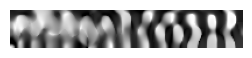

	beta = 12.0
	J = 9.3609e-01
	grad_norm = 4.0679e-01
	penalty = 0.314
	mode power = 70509.692
	dip power = 72879.455
	coupling efficiency = 0.967
Iteration = (59 / 100)


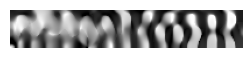

	beta = 12.0
	J = 9.3791e-01
	grad_norm = 2.0113e-01
	penalty = 0.311
	mode power = 41804.340
	dip power = 43143.020
	coupling efficiency = 0.969
Iteration = (60 / 100)


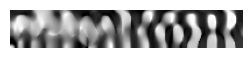

	beta = 12.0
	J = 9.4025e-01
	grad_norm = 2.5264e-01
	penalty = 0.307
	mode power = 25748.521
	dip power = 26517.867
	coupling efficiency = 0.971
Iteration = (61 / 100)


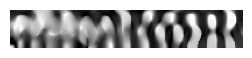

	beta = 13.0
	J = 9.4298e-01
	grad_norm = 1.9770e-01
	penalty = 0.289
	mode power = 18771.299
	dip power = 19314.514
	coupling efficiency = 0.972
Iteration = (62 / 100)


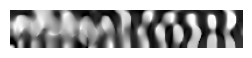

	beta = 13.0
	J = 9.3831e-01
	grad_norm = 2.4655e-01
	penalty = 0.286
	mode power = 36051.354
	dip power = 37283.141
	coupling efficiency = 0.967
Iteration = (63 / 100)


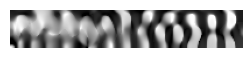

	beta = 13.0
	J = 9.4770e-01
	grad_norm = 3.0916e-01
	penalty = 0.284
	mode power = 73330.091
	dip power = 75124.741
	coupling efficiency = 0.976
Iteration = (64 / 100)


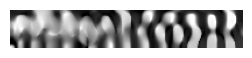

	beta = 13.0
	J = 9.4116e-01
	grad_norm = 2.3562e-01
	penalty = 0.281
	mode power = 48064.009
	dip power = 49586.843
	coupling efficiency = 0.969
Iteration = (65 / 100)


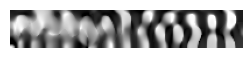

	beta = 13.0
	J = 9.4345e-01
	grad_norm = 2.5314e-01
	penalty = 0.279
	mode power = 34732.187
	dip power = 35758.010
	coupling efficiency = 0.971
Iteration = (66 / 100)


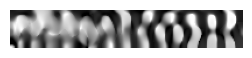

	beta = 14.0
	J = 9.5072e-01
	grad_norm = 1.4767e-01
	penalty = 0.264
	mode power = 28125.287
	dip power = 28783.696
	coupling efficiency = 0.977
Iteration = (67 / 100)


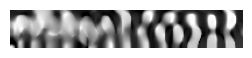

	beta = 14.0
	J = 9.4194e-01
	grad_norm = 2.4715e-01
	penalty = 0.262
	mode power = 46559.660
	dip power = 48091.621
	coupling efficiency = 0.968
Iteration = (68 / 100)


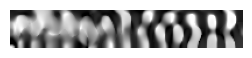

	beta = 14.0
	J = 9.4917e-01
	grad_norm = 2.2277e-01
	penalty = 0.260
	mode power = 72396.961
	dip power = 74239.709
	coupling efficiency = 0.975
Iteration = (69 / 100)


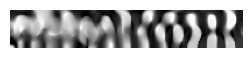

	beta = 14.0
	J = 9.4340e-01
	grad_norm = 2.4728e-01
	penalty = 0.258
	mode power = 50687.983
	dip power = 52298.049
	coupling efficiency = 0.969
Iteration = (70 / 100)


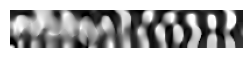

	beta = 14.0
	J = 9.4637e-01
	grad_norm = 2.1213e-01
	penalty = 0.256
	mode power = 46727.818
	dip power = 48073.883
	coupling efficiency = 0.972
Iteration = (71 / 100)


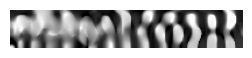

	beta = 15.0
	J = 9.4793e-01
	grad_norm = 2.0206e-01
	penalty = 0.245
	mode power = 43807.749
	dip power = 45051.273
	coupling efficiency = 0.972
Iteration = (72 / 100)


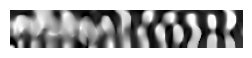

	beta = 15.0
	J = 9.4802e-01
	grad_norm = 2.3269e-01
	penalty = 0.243
	mode power = 65613.204
	dip power = 67481.891
	coupling efficiency = 0.972
Iteration = (73 / 100)


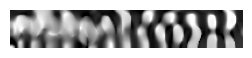

	beta = 15.0
	J = 9.4520e-01
	grad_norm = 2.0955e-01
	penalty = 0.241
	mode power = 58289.876
	dip power = 60136.353
	coupling efficiency = 0.969
Iteration = (74 / 100)


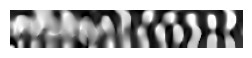

	beta = 15.0
	J = 9.4843e-01
	grad_norm = 1.9381e-01
	penalty = 0.239
	mode power = 59574.966
	dip power = 61270.094
	coupling efficiency = 0.972
Iteration = (75 / 100)


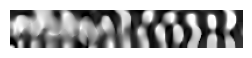

	beta = 15.0
	J = 9.4856e-01
	grad_norm = 1.8808e-01
	penalty = 0.237
	mode power = 71769.585
	dip power = 73817.117
	coupling efficiency = 0.972
Iteration = (76 / 100)


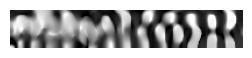

	beta = 16.0
	J = 9.4920e-01
	grad_norm = 2.2412e-01
	penalty = 0.227
	mode power = 34792.815
	dip power = 35798.471
	coupling efficiency = 0.972
Iteration = (77 / 100)


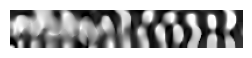

	beta = 16.0
	J = 9.5233e-01
	grad_norm = 1.1844e-01
	penalty = 0.225
	mode power = 49022.100
	dip power = 50286.898
	coupling efficiency = 0.975
Iteration = (78 / 100)


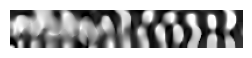

	beta = 16.0
	J = 9.4676e-01
	grad_norm = 4.5962e-01
	penalty = 0.223
	mode power = 112223.050
	dip power = 115803.635
	coupling efficiency = 0.969
Iteration = (79 / 100)


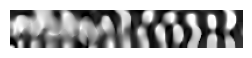

	beta = 16.0
	J = 9.5146e-01
	grad_norm = 2.6840e-01
	penalty = 0.222
	mode power = 24794.677
	dip power = 25465.193
	coupling efficiency = 0.974
Iteration = (80 / 100)


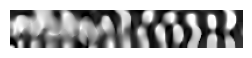

	beta = 16.0
	J = 9.4763e-01
	grad_norm = 2.8706e-01
	penalty = 0.221
	mode power = 20580.707
	dip power = 21223.601
	coupling efficiency = 0.970
Iteration = (81 / 100)


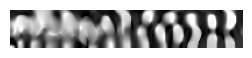

	beta = 17.0
	J = 9.4846e-01
	grad_norm = 2.7118e-01
	penalty = 0.213
	mode power = 26519.913
	dip power = 27347.167
	coupling efficiency = 0.970
Iteration = (82 / 100)


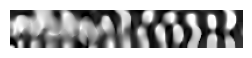

	beta = 17.0
	J = 9.4705e-01
	grad_norm = 2.4277e-01
	penalty = 0.211
	mode power = 83580.160
	dip power = 86326.033
	coupling efficiency = 0.968
Iteration = (83 / 100)


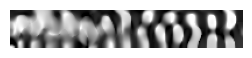

	beta = 17.0
	J = 9.4165e-01
	grad_norm = 4.2922e-01
	penalty = 0.210
	mode power = 107209.997
	dip power = 111366.379
	coupling efficiency = 0.963
Iteration = (84 / 100)


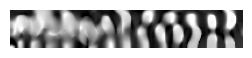

	beta = 17.0
	J = 9.5012e-01
	grad_norm = 2.7870e-01
	penalty = 0.210
	mode power = 26200.887
	dip power = 26981.020
	coupling efficiency = 0.971
Iteration = (85 / 100)


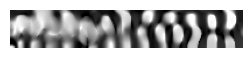

	beta = 17.0
	J = 9.4240e-01
	grad_norm = 3.2850e-01
	penalty = 0.209
	mode power = 22240.250
	dip power = 23088.709
	coupling efficiency = 0.963
Iteration = (86 / 100)


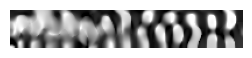

	beta = 18.0
	J = 9.4756e-01
	grad_norm = 2.9047e-01
	penalty = 0.202
	mode power = 21835.585
	dip power = 22562.989
	coupling efficiency = 0.968
Iteration = (87 / 100)


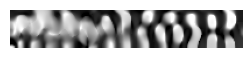

	beta = 18.0
	J = 9.4655e-01
	grad_norm = 2.8581e-01
	penalty = 0.201
	mode power = 44635.553
	dip power = 46177.909
	coupling efficiency = 0.967
Iteration = (88 / 100)


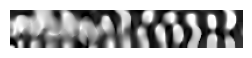

	beta = 18.0
	J = 9.4568e-01
	grad_norm = 1.4660e+00
	penalty = 0.198
	mode power = 191151.713
	dip power = 197978.584
	coupling efficiency = 0.966
Iteration = (89 / 100)


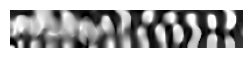

	beta = 18.0
	J = 9.0565e-01
	grad_norm = 7.1548e-01
	penalty = 0.200
	mode power = 7787.385
	dip power = 8413.092
	coupling efficiency = 0.926
Iteration = (90 / 100)


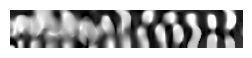

	beta = 18.0
	J = 9.1608e-01
	grad_norm = 5.4755e-01
	penalty = 0.200
	mode power = 3829.103
	dip power = 4090.553
	coupling efficiency = 0.936
Iteration = (91 / 100)


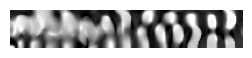

	beta = 19.0
	J = 9.1000e-01
	grad_norm = 4.0796e-01
	penalty = 0.196
	mode power = 3154.019
	dip power = 3393.009
	coupling efficiency = 0.930
Iteration = (92 / 100)


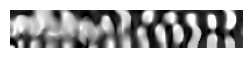

	beta = 19.0
	J = 8.9532e-01
	grad_norm = 4.8212e-01
	penalty = 0.196
	mode power = 3168.027
	dip power = 3462.783
	coupling efficiency = 0.915
Iteration = (93 / 100)


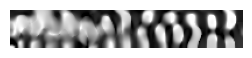

	beta = 19.0
	J = 9.1045e-01
	grad_norm = 3.6817e-01
	penalty = 0.196
	mode power = 3353.528
	dip power = 3605.939
	coupling efficiency = 0.930
Iteration = (94 / 100)


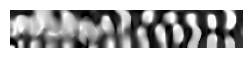

	beta = 19.0
	J = 9.3083e-01
	grad_norm = 2.9490e-01
	penalty = 0.195
	mode power = 3787.969
	dip power = 3985.947
	coupling efficiency = 0.950
Iteration = (95 / 100)


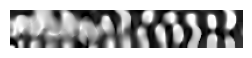

	beta = 19.0
	J = 9.4441e-01
	grad_norm = 2.1215e-01
	penalty = 0.194
	mode power = 4620.248
	dip power = 4793.893
	coupling efficiency = 0.964
Iteration = (96 / 100)


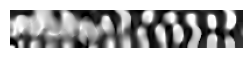

	beta = 20.0
	J = 9.3738e-01
	grad_norm = 2.9252e-01
	penalty = 0.188
	mode power = 5972.530
	dip power = 6246.091
	coupling efficiency = 0.956
Iteration = (97 / 100)


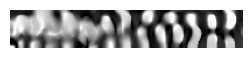

	beta = 20.0
	J = 9.4350e-01
	grad_norm = 2.2733e-01
	penalty = 0.186
	mode power = 9200.513
	dip power = 9562.867
	coupling efficiency = 0.962
Iteration = (98 / 100)


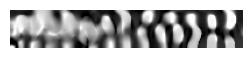

	beta = 20.0
	J = 9.5092e-01
	grad_norm = 1.1442e-01
	penalty = 0.184
	mode power = 15828.774
	dip power = 16330.019
	coupling efficiency = 0.969
Iteration = (99 / 100)


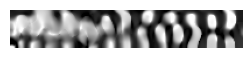

	beta = 20.0
	J = 9.4448e-01
	grad_norm = 1.1112e-01
	penalty = 0.182
	mode power = 30118.514
	dip power = 31287.115
	coupling efficiency = 0.963
Iteration = (100 / 100)


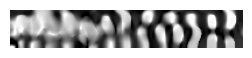

	beta = 20.0
	J = 9.3400e-01
	grad_norm = 1.4951e-01
	penalty = 0.179
	mode power = 60020.849
	dip power = 63053.450
	coupling efficiency = 0.952


In [17]:
iter_done = len(history_dict["values"])
if iter_done < max_iter:
    # small # of iters for quick testing
    for i in range(iter_done, max_iter):
        print(f"Iteration = ({i + 1} / {max_iter})")
        plt.subplots(1, 1, figsize=(3, 2))
        plt.imshow(np.flipud(1 - params.T), cmap="gray", vmin=0, vmax=1)
        plt.axis("off")
        plt.show()

        # Compute gradient and current objective function value.
        beta_i = i // iter_steps + beta_min
        (value, gradient), data = obj_grad(params, beta=beta_i, step_num=(i + 1))
        sim_data_i, mode_power_i, dip_power_i, penalty_val_i = [data[0]] + [
            dat._value for dat in data[1:]
        ]
        # Outputs.
        print(f"\tbeta = {beta_i}")
        print(f"\tJ = {value:.4e}")
        print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")
        print(f"\tpenalty = {penalty_val_i:.3f}")
        print(f"\tmode power = {mode_power_i:.3f}")
        print(f"\tdip power = {dip_power_i:.3f}")
        print(f"\tcoupling efficiency = {mode_power_i / dip_power_i:.3f}")

        # Compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn).
        updates, opt_state = optimizer.update(-gradient, opt_state, params)
        params = optax.apply_updates(params, updates)

        # Cap parameters between 0 and 1.
        params = anp.minimum(params, 1.0)
        params = anp.maximum(params, 0.0)

        # Save history.
        history_dict["values"].append(value)
        history_dict["coupl_eff"].append(mode_power_i / dip_power_i)
        history_dict["penalty"].append(penalty_val_i)
        history_dict["params"].append(params)
        history_dict["beta"].append(beta_i)
        history_dict["gradients"].append(gradient)
        history_dict["opt_states"].append(opt_state)
        # history_dict["data"].append(sim_data_i)  # Uncomment to store data, can create large files.
        save_history(history_dict)

Ultimately, we get all the information to assess the optimization results.

In [18]:
obj_vals = np.array(history_dict["values"])
ce_vals = np.array(history_dict["coupl_eff"])
pen_vals = np.array(history_dict["penalty"])
final_par_density = history_dict["params"][-1]
final_beta = history_dict["beta"][-1]

In [19]:
# just to inspect design at different iterations
def unfold_params(params):
    params = np.concatenate((np.fliplr(np.copy(params)), params), axis=1)
    return params


params1 = history_dict["params"][32]
params1_full = pre_process(params1, beta=final_beta)
params1_full = include_constant_regions(
    params1_full, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r
)
params1_full = unfold_params(params1_full)

params2 = history_dict["params"][-1]
params2_full = pre_process(params2, beta=final_beta)
params2_full = include_constant_regions(
    params2_full, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r
)
params2_full = unfold_params(params2_full)

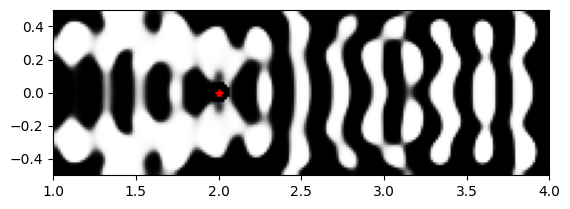

In [20]:
plt.imshow(
    1 - np.flipud(params1_full.T),
    cmap="gray",
    vmin=0,
    vmax=1,
    extent=[wg_length, cr_l + wg_length, -cr_w / 2, cr_w / 2],
)
plt.plot(dp_source.center[0], 0, "r*")
plt.show()

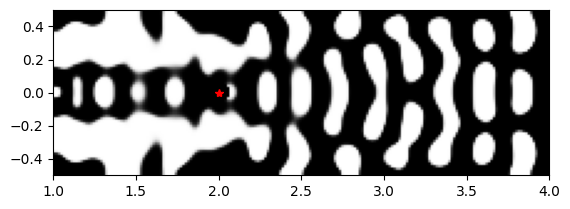

In [21]:
plt.imshow(
    1 - np.flipud(params2_full.T),
    cmap="gray",
    vmin=0,
    vmax=1,
    extent=[wg_length, cr_l + wg_length, -cr_w / 2, cr_w / 2],
)
plt.plot(dp_source.center[0], 0, "r*")
plt.show()

### Results
The following figure shows how coupling efficiency and the fabrication penalty have evolved along the optimization process. The coupling efficiency quickly rises above 0.8, and along the binarization process, we can observe two large drops before a more stable final optimization stage. The formation of resonant modes sensitive to the small structural changes can potentially explain this behavior. The discontinuities in the fabrication penalty curve are caused by the increments in the projection parameter beta at each 5 iterations.

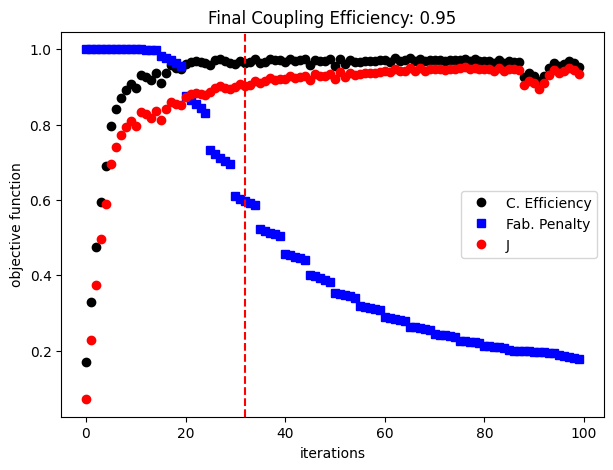

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(ce_vals, "ko", label="C. Efficiency")
ax.plot(pen_vals, "bs", label="Fab. Penalty")
ax.plot(history_dict["values"], "ro", label="J")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final Coupling Efficiency: {ce_vals[-1]:.2f}")
ax.axvline(x=32, color="r", linestyle="--")

ax.legend()
plt.show()

Interestingly, fully binarizing the design from iteration 32 produced a device with great coupling efficiency (~97%), but minimal purcell enhancement

Text(0.5, 0, 'iteration')

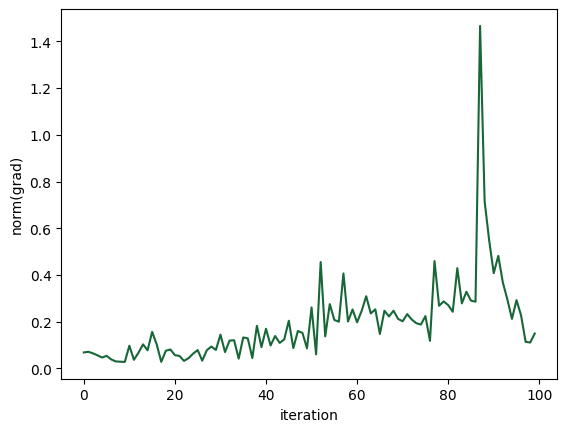

In [23]:
plt.plot([np.linalg.norm(grad) for grad in history_dict["gradients"]])
plt.ylabel("norm(grad)")
plt.xlabel("iteration")

Makes a nice animation of the design parameters and gradient evolution during the optimization

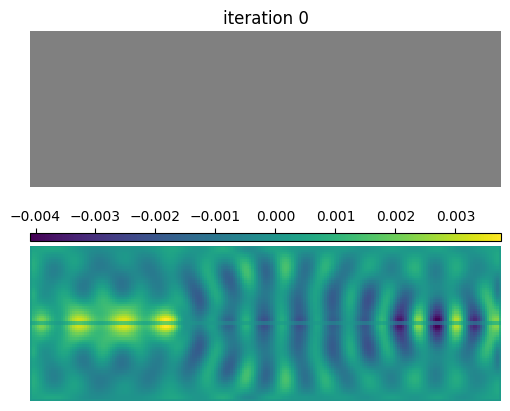

In [24]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(nrows=2, ncols=1)

gradients = history_dict["gradients"]
params = history_dict["params"]
gradients = [unfold_params(grad).T for grad in gradients]
params = [unfold_params(init_par).T] + [unfold_params(1.0 - p).T for p in params]

div = make_axes_locatable(axs[1])
div0 = make_axes_locatable(axs[0])
cax = div.append_axes("top", size="5%", pad=0.05)
cax0 = div0.append_axes("bottom", size="5%", pad=0.05)
cax0.axis("off")


def animate(i):
    im_g = axs[1].imshow(
        gradients[i], interpolation="none", vmin=np.min(gradients[i]), vmax=np.max(gradients[i])
    )
    axs[0].imshow(params[i], interpolation="none", cmap="gray", vmin=0, vmax=1)
    axs[1].axis("off")
    axs[0].axis("off")
    cax.cla()
    fig.colorbar(im_g, cax=cax, orientation="horizontal").ax.xaxis.set_ticks_position("top")

    axs[0].set_title(f"iteration {i}")


anim = animation.FuncAnimation(fig, animate, frames=100, blit=False, interval=500)
anim.save("autograd_anim.mp4", fps=2.0)

Interestingly, the final quantum emitter light extractor resembles a nanocavity, even though we have considered only the coupling efficiency into the output waveguide in the optimization. We have DBR mirrors on both sides of the dipole. However, on the left side, the mirror has only a few periods and partially reflects the radiation, which couples to the output waveguide.

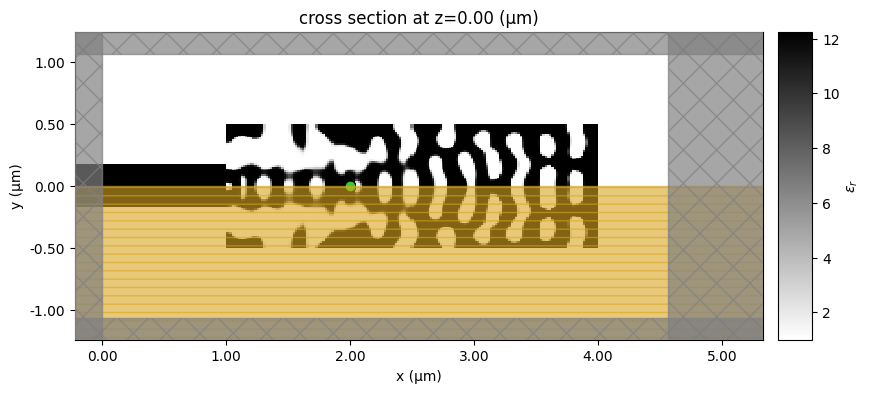

In [25]:
# here, removing substrate improved performance, but also blue-shifted cavity resonance a bit.

fig, ax = plt.subplots(1, figsize=(10, 4))
# Substrate layer.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -wg_thick / 2)
    ),
    medium=td.Medium(permittivity=1.0),
)
sim_final = make_adjoint_sim(params2, beta=final_beta, unfold=True)
sim_final = sim_final.updated_copy(monitors=[field_monitor_xy, mode_monitor] + field_monitor)
sim_final.plot_eps(
    z=0,
    source_alpha=0,
    monitor_alpha=0,
    ax=ax,
)
plt.show()

To better understand the resultant design, let's simulate the final structure to obtain its spectral response and field distribution.

In [26]:
sim_data_final = web.run(sim_final, task_name="final QE light extractor")

18:56:12 CEST Created task 'final QE light extractor' with task_id              
              'fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=23040;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=544309;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\taskId]8;;\]8;id=23040;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\=]8;;\]8;id=299999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\fdve]8;;\]8;id=23040;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\-7b5a7f2b-9d]8;;\
              ]8;id=23040;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\da-46bc-8519-0af1e82273c8']8;;\.

              Task folder: ]8;id=921760;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

18:56:14 CEST Maximum FlexCredit cost: 0.058. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:56:15 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:56:27 CEST starting up solver

              running solver

Output()

18:56:36 CEST early shutoff detected at 24%, exiting.

              status = postprocess

Output()

18:56:41 CEST status = success

18:56:43 CEST View simulation result at                                         
              ]8;id=743023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=674217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\taskId]8;;\]8;id=743023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\=]8;;\]8;id=219970;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\fdve]8;;\]8;id=743023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\-7b5a7f2b-9d]8;;\
              ]8;id=743023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7b5a7f2b-9dda-46bc-8519-0af1e82273c8\da-46bc-8519-0af1e82273c8']8;;\.

Output()

18:56:47 CEST loading simulation from simulation_data.hdf5

In this cavity-like system, the extraction efficiency of photons from the QE into the collection waveguide mode is proportional to $\beta\times C_{wg}$, where the $\beta$-factor quantifies the fraction of the QE spontaneous emission emitted in the cavity mode, and $C_{wg}$ is the fraction of the cavity photons coupled to the guided mode `A. Enderlin, Y. Ota, R. Ohta, N. Kumagai, S. Ishida, S. Iwamoto, and Y. Arakawa, "High guided mode–cavity mode coupling for an efficient extraction of spontaneous emission of a single quantum dot embedded in a photonic crystal nanobeam cavity," Phys. Rev. B 86, 075314 (2012)` [DOI: 10.1103/PhysRevB.86.075314](https://link.aps.org/doi/10.1103/PhysRevB.86.075314). By the field distribution image below, we can see a cavity mode resonance, which should increase the Purcell factor at the QE position, thus contributing to a higher $\beta$-factor. At the same time, the partial reflection mirror at the left side was potentially optimized to adjust $C_{wg}$.

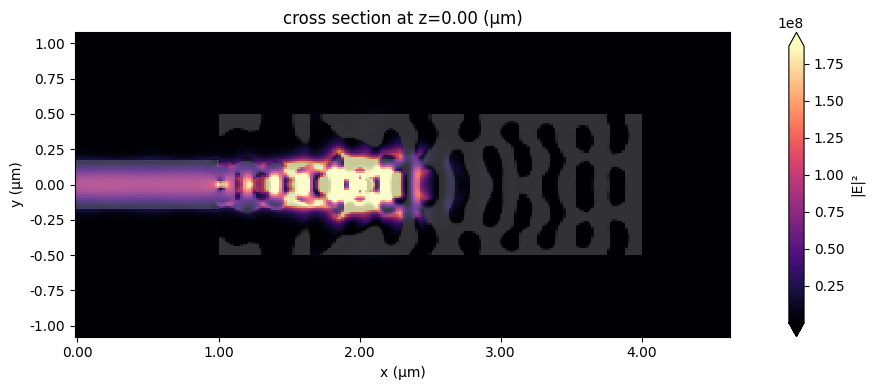

In [27]:
f, ax1 = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)
sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax1, f=freqs[0])
plt.show()

To conclude, we will calculate the final coupling efficiency and the cavity Purcell value. The coupling efficiency is above 80% along an extensive wavelength range, and we have confirmed the Purcell enhancement.

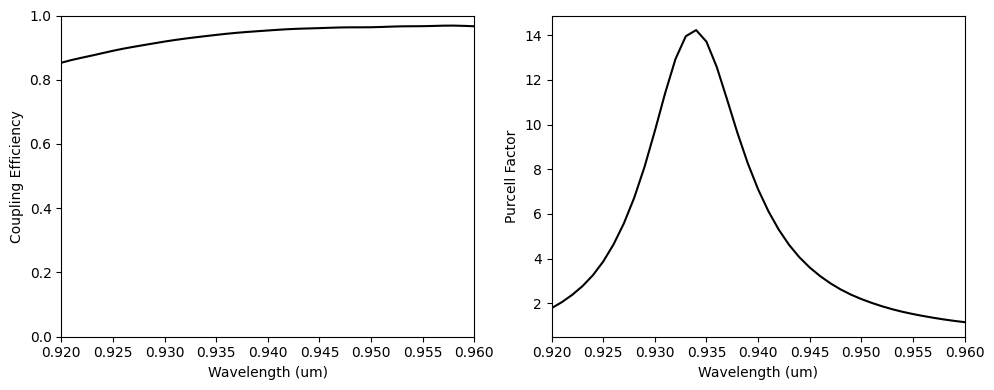

In [28]:
# Coupling efficiency.
mode_amps = sim_data_final["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data_final[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)
coup_eff = mode_power / dip_power

# Purcell factor.
bulk_power = ((2 * np.pi * freqs) ** 2 / (12 * np.pi)) * (td.MU_0 * n_wg / td.C_0)
bulk_power = bulk_power * 2 ** (2 * np.sum(np.abs(sim_final.symmetry)))
purcell = dip_power / bulk_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
ax2.plot(wl_range, purcell, "-k")
ax2.set_xlabel("Wavelength (um)")
ax2.set_ylabel("Purcell Factor")
ax2.set_xlim(wl - bw / 2, wl + bw / 2)
plt.show()

In [29]:
print(np.max(coup_eff.values))
print(np.min(coup_eff.values))

0.9685581762335904
0.8529465434212032


## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [30]:
# make the misc/ directory to store the GDS file if it doesn't exist already
import os

if not os.path.exists("./misc/"):
    os.mkdir("./misc/")

sim_final.to_gds_file(
    fname="./misc/inv_des_light_extractor_autograd.gds",
    z=0,
    permittivity_threshold=(eps_max + eps_min) / 2,
    frequency=freq,
)